# Evaluating Stability of Useful Nanobodies

## Background
We would like to evaluate the fitness of nanobodies that are *useful* in that they are either present in structures in the PDB or listed in patents. Our hypothesis is that these are going to be, on the whole, more fit than a random set of nanobodies due to their selection by scientists, in part, as a result of their developability.

The data were obtained from the [INDI](https://research.naturalantibody.com/nanobodies) database. This database collects nanobody sequences from a variety of public sources. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from Bio import SeqIO
%matplotlib inline

from nabstab.datasets.classifier_dataset import pad_cdr2, pad_internal, NbStabilityDataset
from nabstab.models.fitness_classifier import OmnilibStabilityPredictor, ConvNet, LinearNet, FC
from nabstab.utils import (
    AA2INDEX,
    load_model,
    plot_scores_cnn,
    plot_scores_lr,
    dms_redesign
)

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

## Data Preprocessing

The data were preprocessed in the following way:
 1. Run ANARCI to get the CDR boundaries
 2. Extract the CDRs, and check for compliance with our model's training data
    - Lengths: `cdr1 == 7`, `cdr2 in [12,13]`, `cdr3 <= 28`
    - No 'C' in CDR2. This comes from V genes that are different from the scaffold used in the model.
 3. Score the sequences with the LR and CNN Models

In [2]:
## Get the paths setup
from pathlib import Path
if '__file__' in globals():
    current_dir = Path(__file__).resolve().parent
else:
    current_dir = Path.cwd()

data_dir = current_dir.parent / 'data'
checkpoints_dir = current_dir.parent / 'model_checkpoints'

In [3]:
processed_data_dir = data_dir / 'patent_nb_data'

pdb_data_file = processed_data_dir / 'pdb_scored.csv'
patent_data_file = processed_data_dir / 'patent_scored.csv'

#load
pdb_data = pd.read_csv(pdb_data_file)
patent_data = pd.read_csv(patent_data_file)

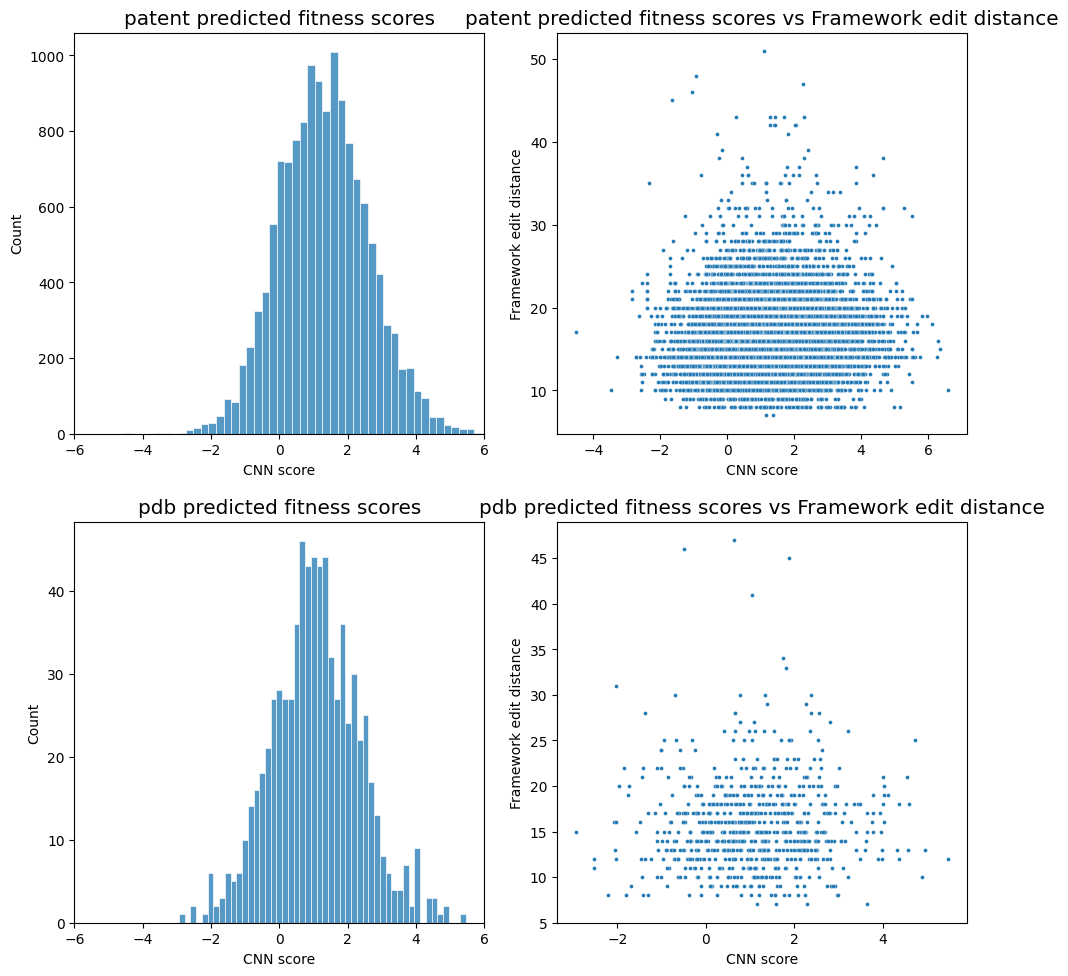

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.set_theme(style='whitegrid', font_scale=1.2)

datasets = ['patent', 'pdb']
for i, data in enumerate([patent_data, pdb_data]):
    sns.histplot(data = data, x='CNN', ax=axs[i, 0], bins=50)
    sns.scatterplot(data = data , x='CNN', y='edit_distance', ax=axs[i, 1], s=8)
    
    axs[i, 0].set_title(f'{datasets[i]} CNN scores')
    axs[i, 1].set_title(f'{datasets[i]} CNN scores vs Framework edit distance')

    axs[i, 0].set_xlabel('CNN score')
    axs[i, 0].set_ylabel('Count')

    axs[i, 1].set_xlabel('CNN score')
    axs[i, 1].set_ylabel('Framework edit distance')

    axs[i, 0].set_title(f'{datasets[i]} predicted fitness scores')
    axs[i, 1].set_title(f'{datasets[i]} predicted fitness scores vs Framework edit distance')

    axs[i, 0].set_xlim(-6, 6)


plt.tight_layout()

fig.savefig(current_dir / 'figure_6_outputs' / 'all_patent_structure_scores.pdf')

## Rescue Screening

For 5 manually picked patent NB sequences, we apply the same rescuing framework as in Figure 5.

### Load models

In [5]:
lr_checkpoint = checkpoints_dir / 'LR/20231223_LR.pt'
cnn_checkpoint = checkpoints_dir / 'CNN/cnn_24_fc_8.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr_model = load_model(
    checkpoint_path=lr_checkpoint,
    model_type='lr',
    device=device
)

cnn_model = load_model(
    checkpoint_path=cnn_checkpoint,
    model_type='cnn',
    device=device
)


In [6]:
lowfitness_path = processed_data_dir / 'Lowfitness_patent_Nb.csv'
df = pd.read_csv(lowfitness_path)

unseen_weights = np.load(current_dir / 'figure_5_outputs/unseen_weights.npy')

bases = []
dms_preds = []
sequence_tensors = []

for i, row in df.iterrows():
    pred = row['CNN']
    seq = row['padded_sequence']
    seq = torch.tensor([AA2INDEX[aa] for aa in seq]).unsqueeze(0)

    preds = dms_redesign(cnn_model, seq, device)

    bases.append(pred)
    dms_preds.append(preds)
    sequence_tensors.append(seq)

## Look at the current positional contributions

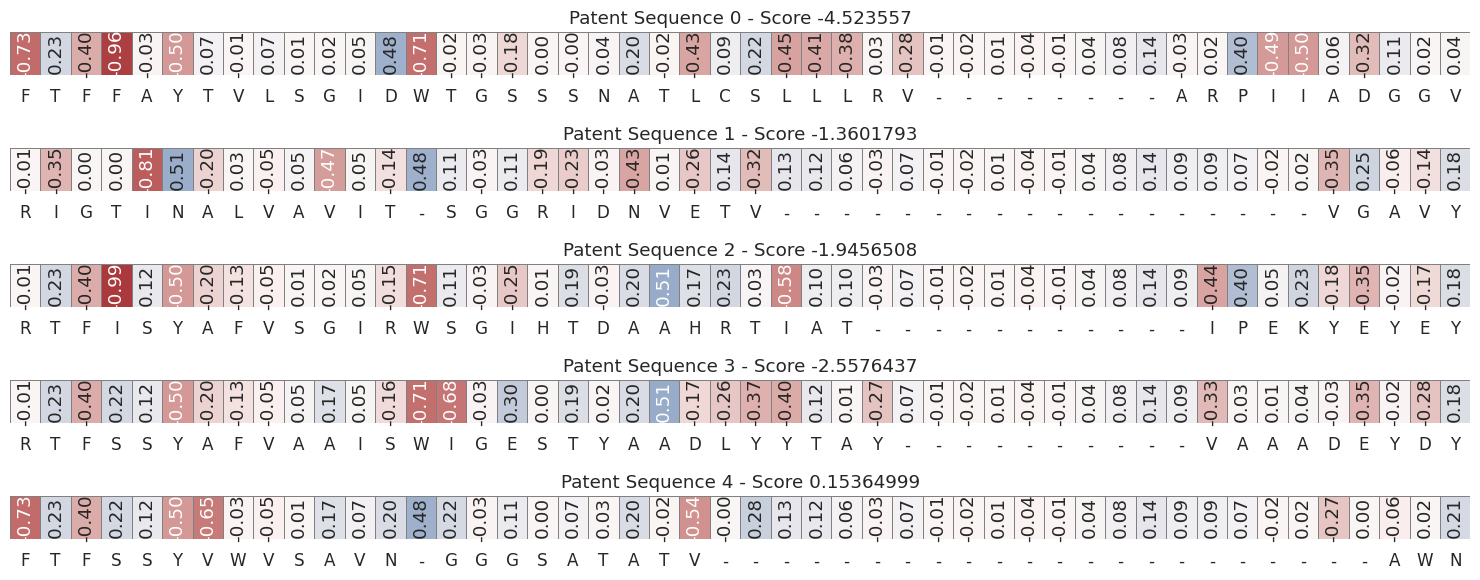

In [14]:
lr_weights = lr_model.classifier.linear.weight.detach().cpu().reshape(21, -1)
fig, axs = plt.subplots(5,1, figsize=(15, 6))

sns.set_theme(style='white', font_scale=1.1)

for i, seq in enumerate(sequence_tensors):
    seqscores = torch.gather(lr_weights, 0, seq)
    sns.heatmap(seqscores, ax=axs[i], cmap='vlag_r', center=0, vmin = -1, vmax=1, cbar=False, xticklabels=df['padded_sequence'].values[i], linecolor='gray', linewidth=0.5, annot=True, fmt='.2f', annot_kws={'rotation': 90})
    axs[i].set_title(f'Patent Sequence {i} - Score {df["LR"].values[i]}')

    with open(current_dir / 'figure_6_outputs' / f'lr_heatmap_patent_sequence_{i}.txt', 'w') as f:
        for pos, score in zip(df['padded_sequence'].values[i], seqscores.squeeze().numpy()):
            f.write(f'{pos} {score:.3f}\n')

for a in axs:
    a.set_yticks([])

plt.tight_layout()

fig.savefig(current_dir / 'figure_6_outputs' / 'lr_heatmap_patent_sequences.pdf')

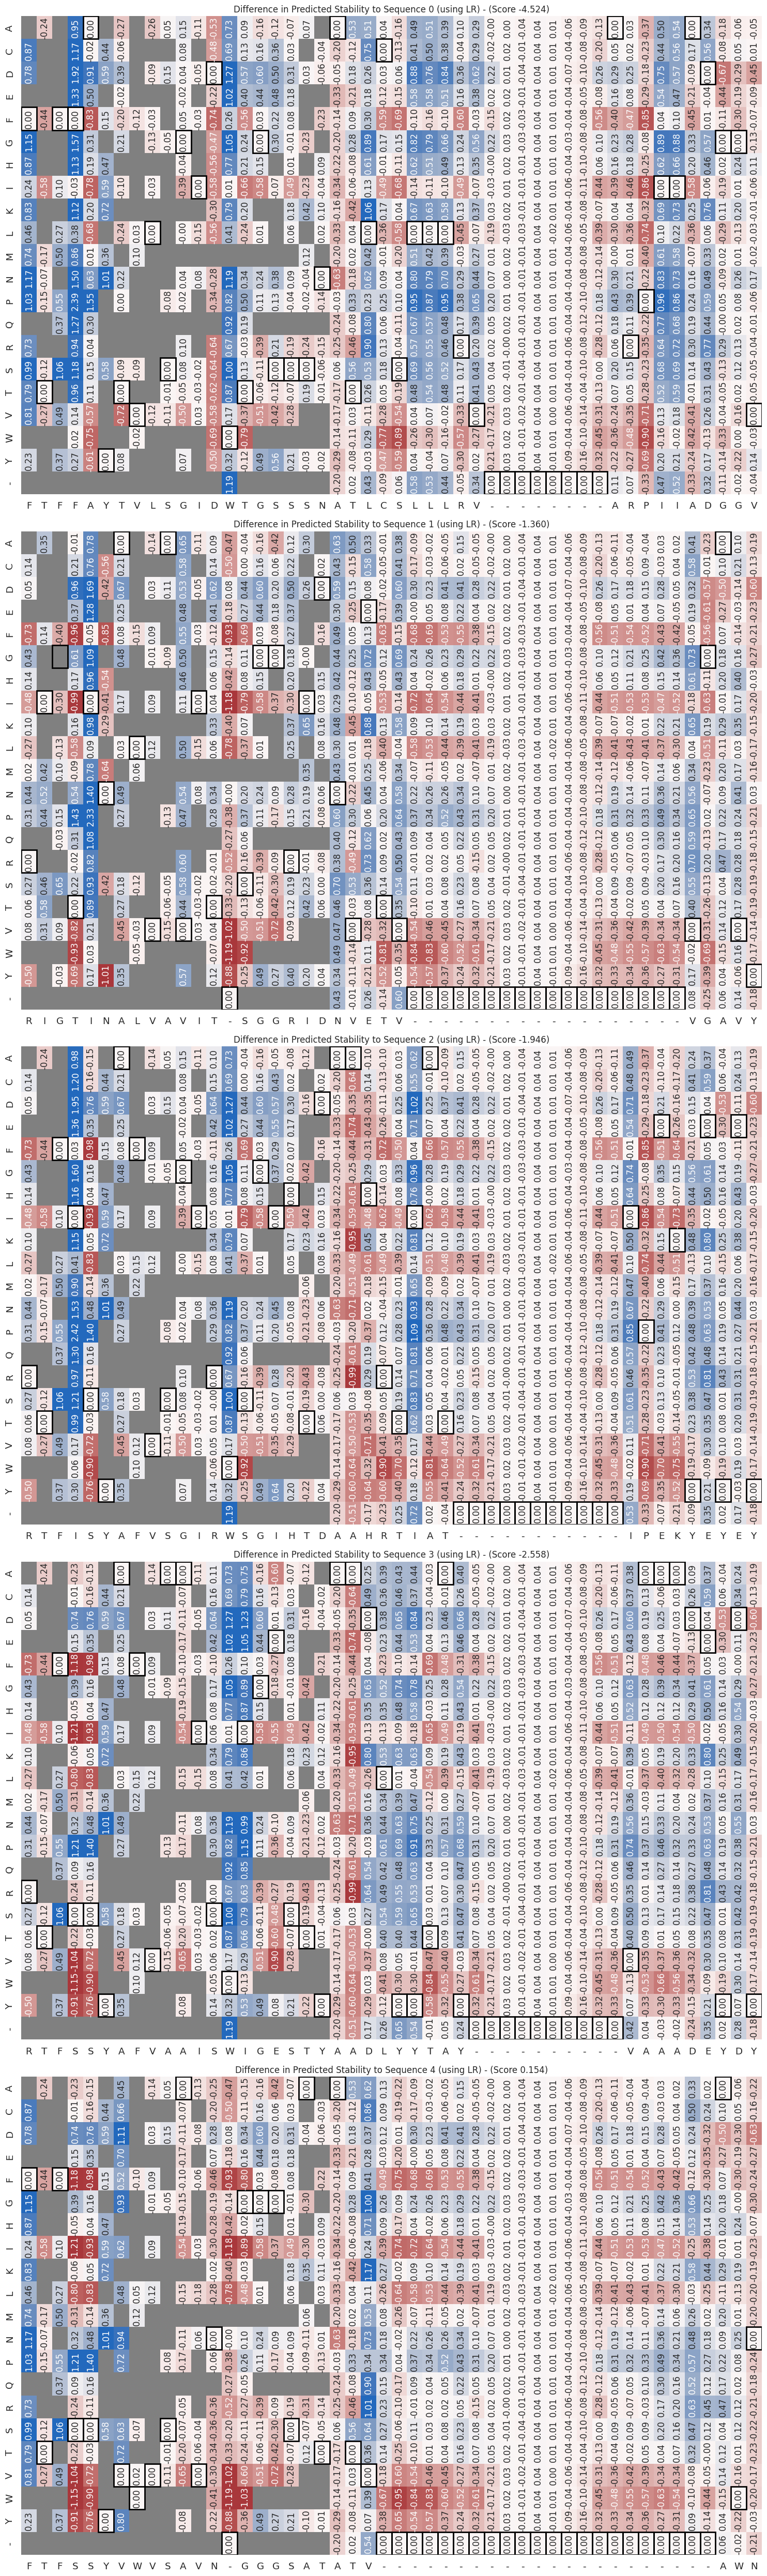

In [7]:
output_lr_heatmaps_fname = current_dir / 'figure_6_outputs' / 'lr_heatmaps.pdf'
output_cnn_heatmaps_fname = current_dir / 'figure_6_outputs' / 'cnn_heatmaps.pdf'

plot_scores_lr(
    lr_model,
    sequence_tensors,
    df = df,
    unseen_weights= torch.tensor(unseen_weights),
    filename= output_lr_heatmaps_fname
)

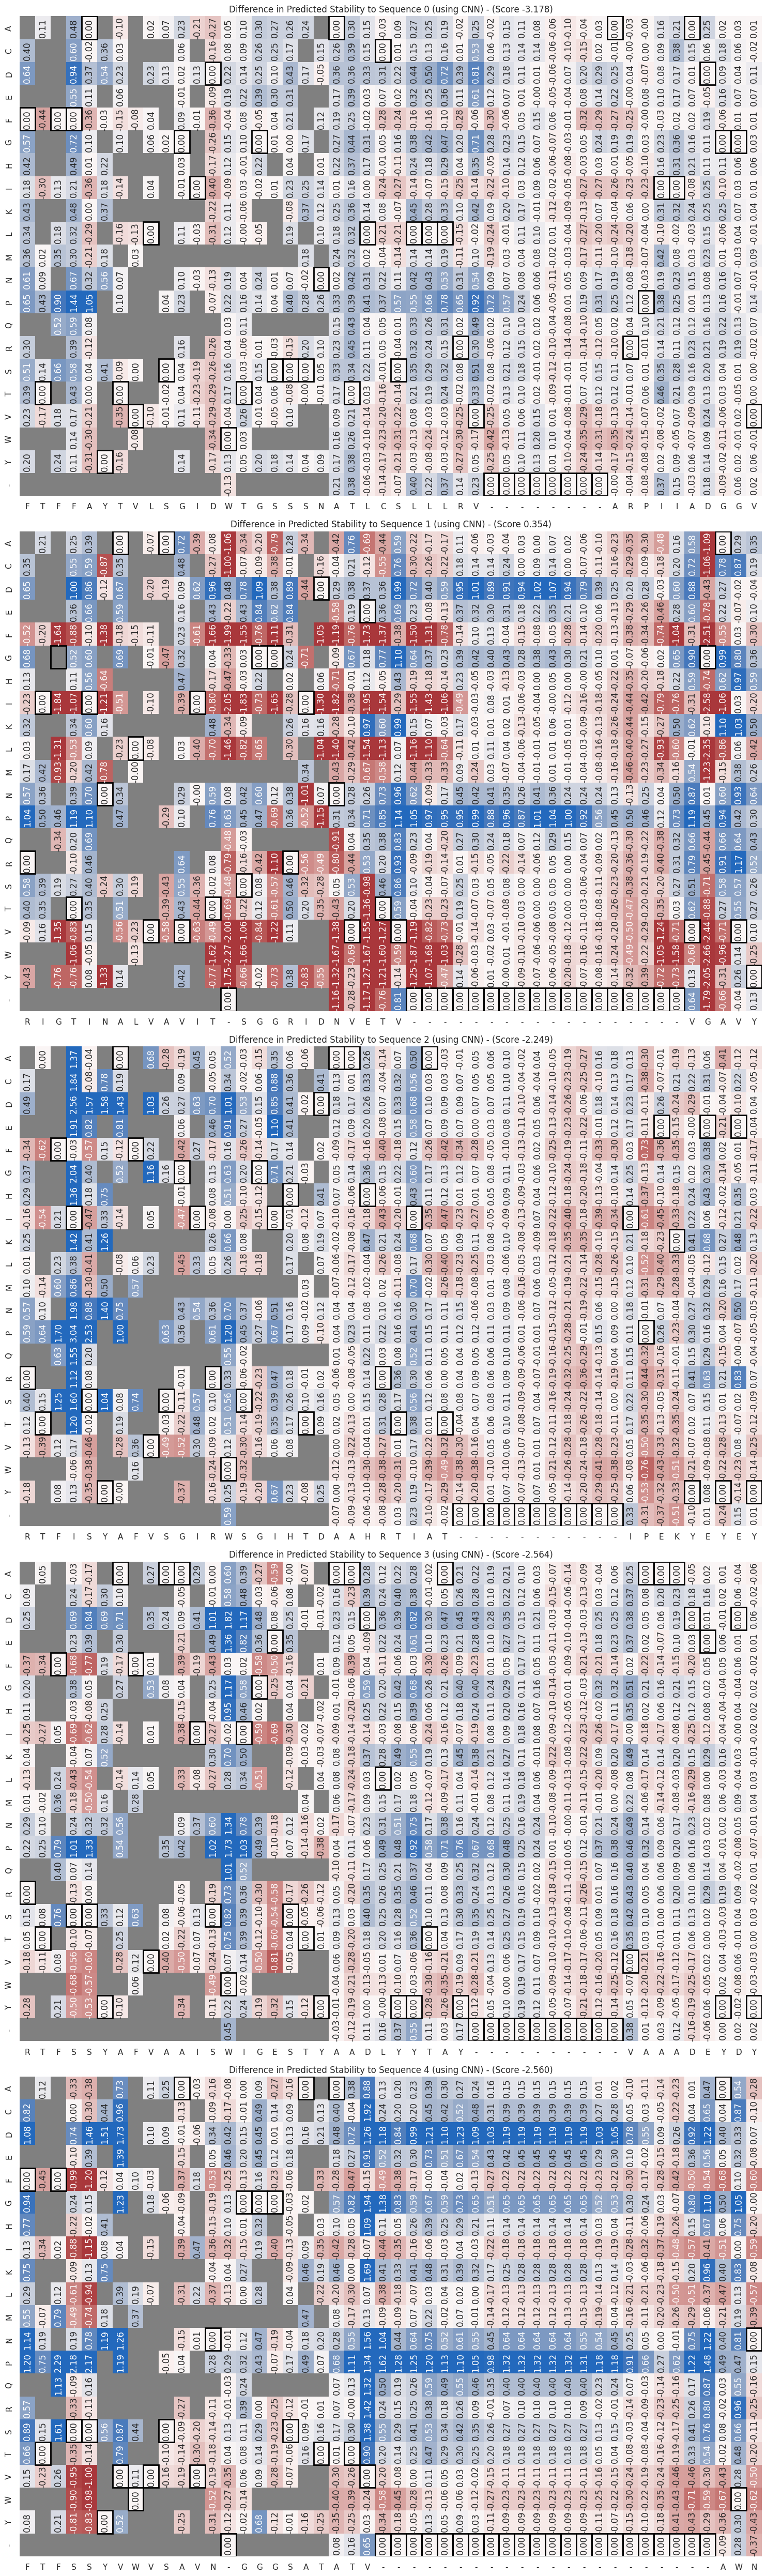

In [8]:
plot_scores_cnn(
    base_scores=bases,
    dms_scores=dms_preds,
    sequence_tensors=sequence_tensors,
    df=df,
    unseen_weights= torch.tensor(unseen_weights),
    filename= output_cnn_heatmaps_fname
)

In [11]:
#save the data
for i, (base_score, dms_score) in enumerate(zip(bases, dms_preds)):
    diff = dms_score - base_score
    diff_masked = diff.T *~unseen_weights

    diff_df = pd.DataFrame(diff_masked, columns=list(df.padded_sequence.values[i]), index = AA2INDEX.keys())
    diff_df.to_csv(current_dir / 'figure_6_outputs' / f'cnn_heatmap_{i}.csv')